Este conjunto de dados contém informações sobre carros usados listados em www.cardekho.com
Esses dados podem ser usados para diversos fins, como previsão de preços, para exemplificar o uso de regressão linear no aprendizado de máquina.


Vamos usar ele para fzer um experimento das bibliotecas StatsModels e Sklearn

# 0.0 Imports

In [166]:
import pandas as pd
import numpy as np

#  viz
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
import seaborn as sns


# statsmodels
from scipy                    import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Help Functions

In [163]:
# adjust jupyter notebook viz
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()


def crammer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()
    # n = soma de linhas
    n = cm.sum()
    # r, k nr de linhas e colunas respectivamente
    r,k = cm.shape
    
    # correcao das equacoes para evitar bias
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 -(k-1)*(r-1)/(n-1))
    
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return  np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1))  )

Populating the interactive namespace from numpy and matplotlib


# 1.0 Import Data

In [117]:
df = pd.read_csv('datasets_33080_1320127_CAR DETAILS FROM CAR DEKHO.csv')

In [413]:
df.shape

(4340, 8)

In [119]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [120]:
df['km_driven'].max()

806599

In [121]:
cat_vars = df.select_dtypes(include = ['object'])
num_vars = df.select_dtypes(exclude = ['object'])

In [122]:
cat_vars.describe()

,name,fuel,seller_type,transmission,owner
count,4340,4340,4340,4340,4340
unique,1491,5,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,69,2153,3244,3892,2832


In [123]:
num_vars['selling_price'].max()

8900000

## 1.2 Descriptive Analysis

In [124]:
df1 = df.copy()

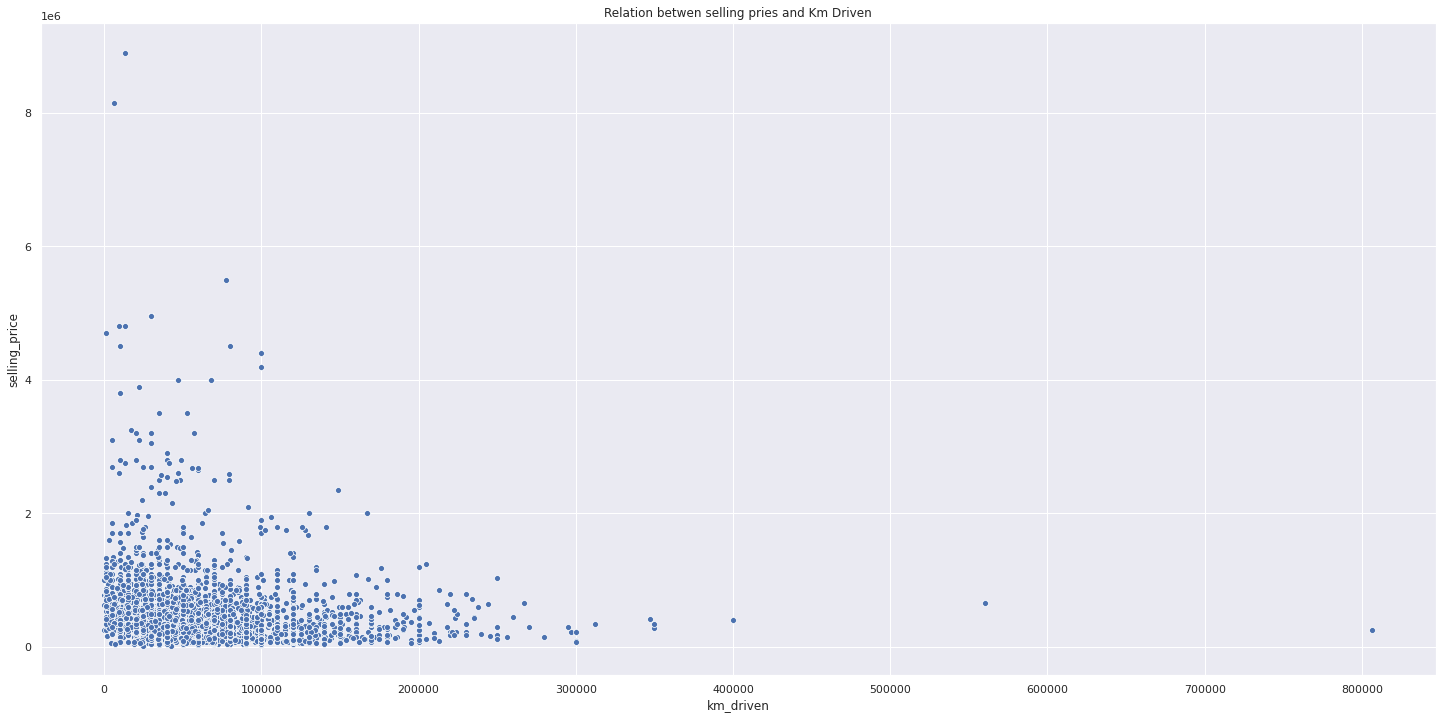

In [179]:
# Numeric vars distributions

# num_vars.hist( bins = 50);
plt.title('Relation betwen selling pries and Km Driven')
sns.scatterplot(x= 'km_driven', y = 'selling_price', data = df1)

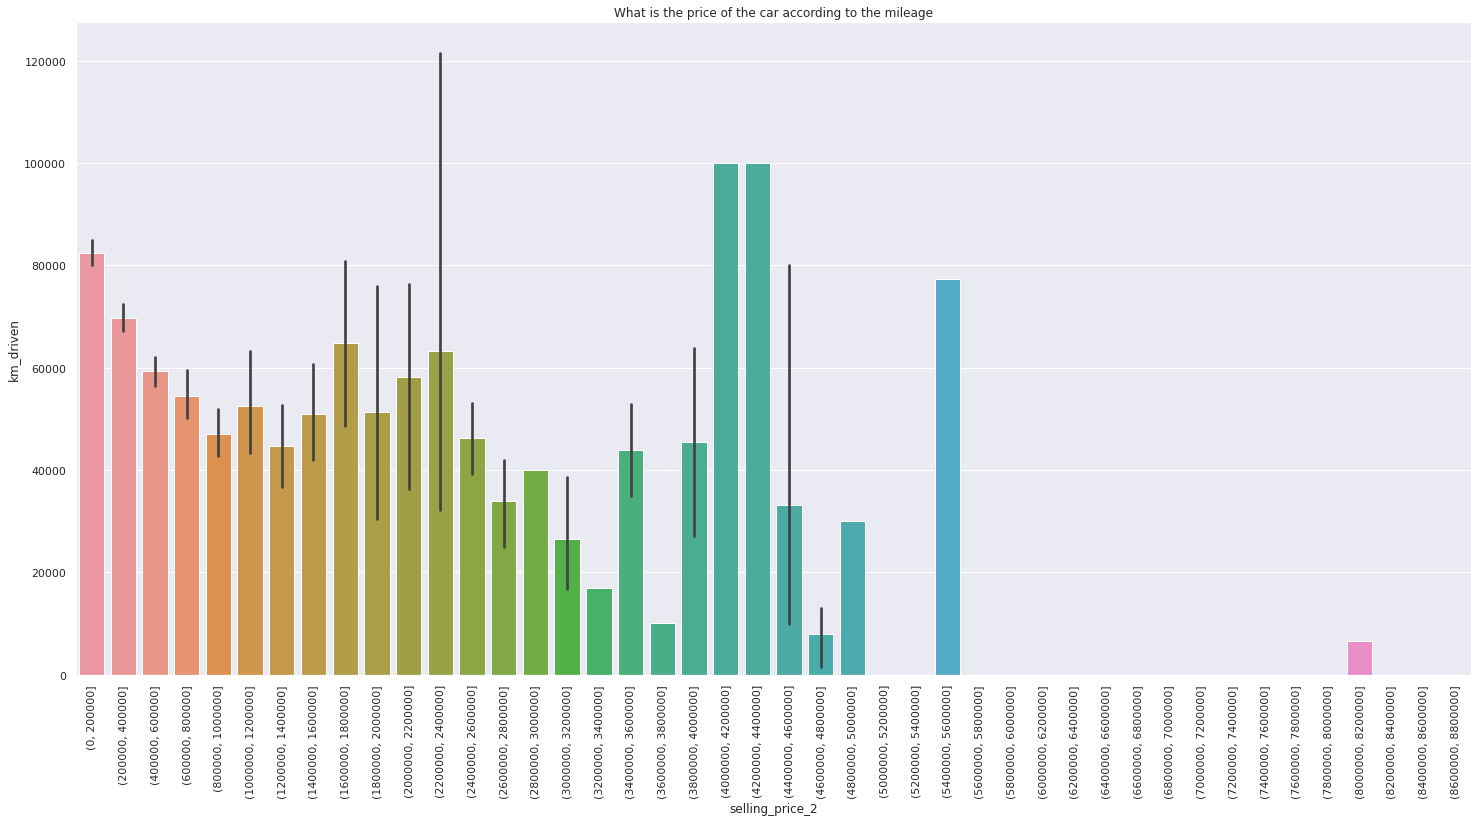

In [180]:

bins = list(np.arange(0,8900000,200000))
bins2 = list(np.arange(0,806599,20000))

df1['selling_price_2'] = pd.cut(df['selling_price'], bins = bins)
df1['km_driven_2'] = pd.cut(df['selling_price'], bins = bins2)

plt.title('What is the price of the car according to the mileage')
sns.barplot( x = 'selling_price_2', y = 'km_driven', data = df1)
plt.xticks( rotation = 90);


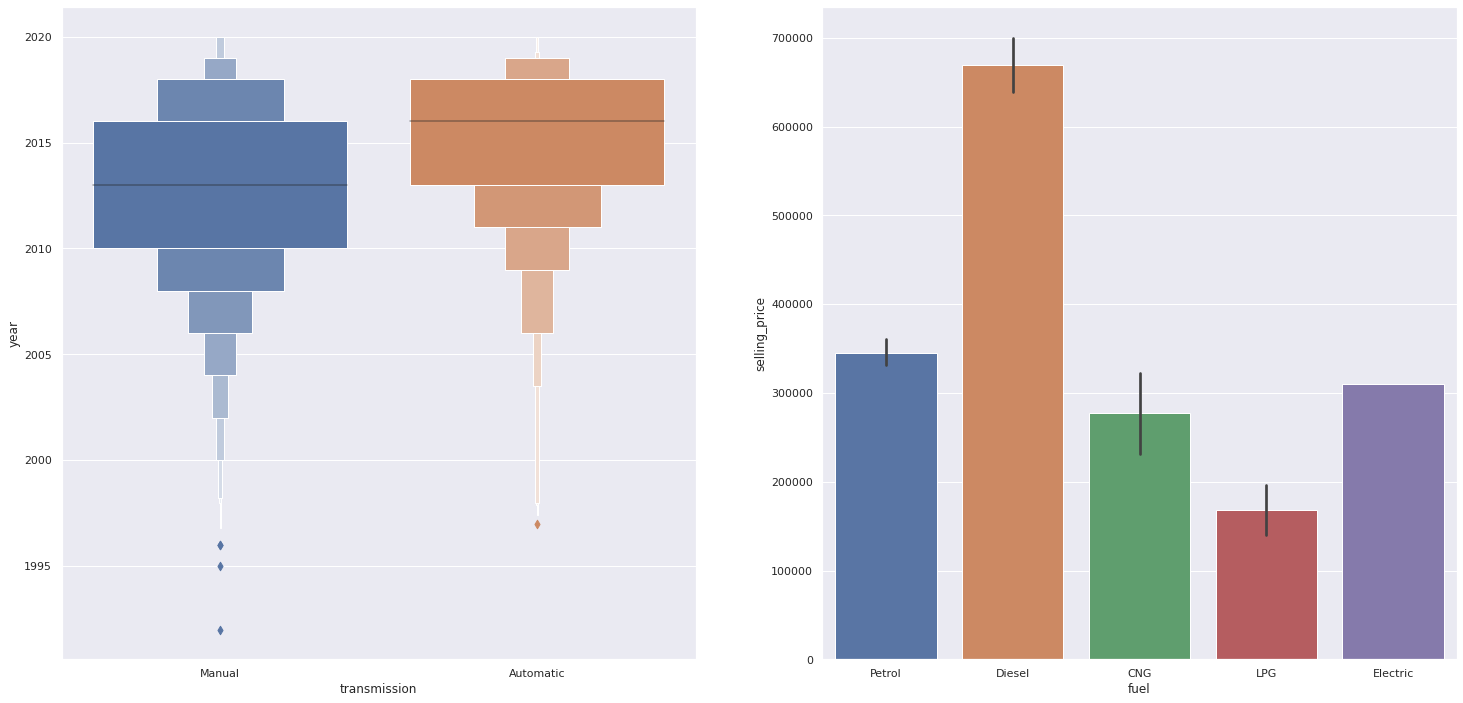

In [139]:
plt.subplot(1,2,1)
plt.title('Car type ratio and sales statistics over the years')
sns.boxenplot( x = 'transmission', y ='year' , data = df1)

plt.subplot(1,2,2)
plt.title('Number of sales by fuel type')
sns.barplot(x = 'fuel', y = 'selling_price', data = df1);

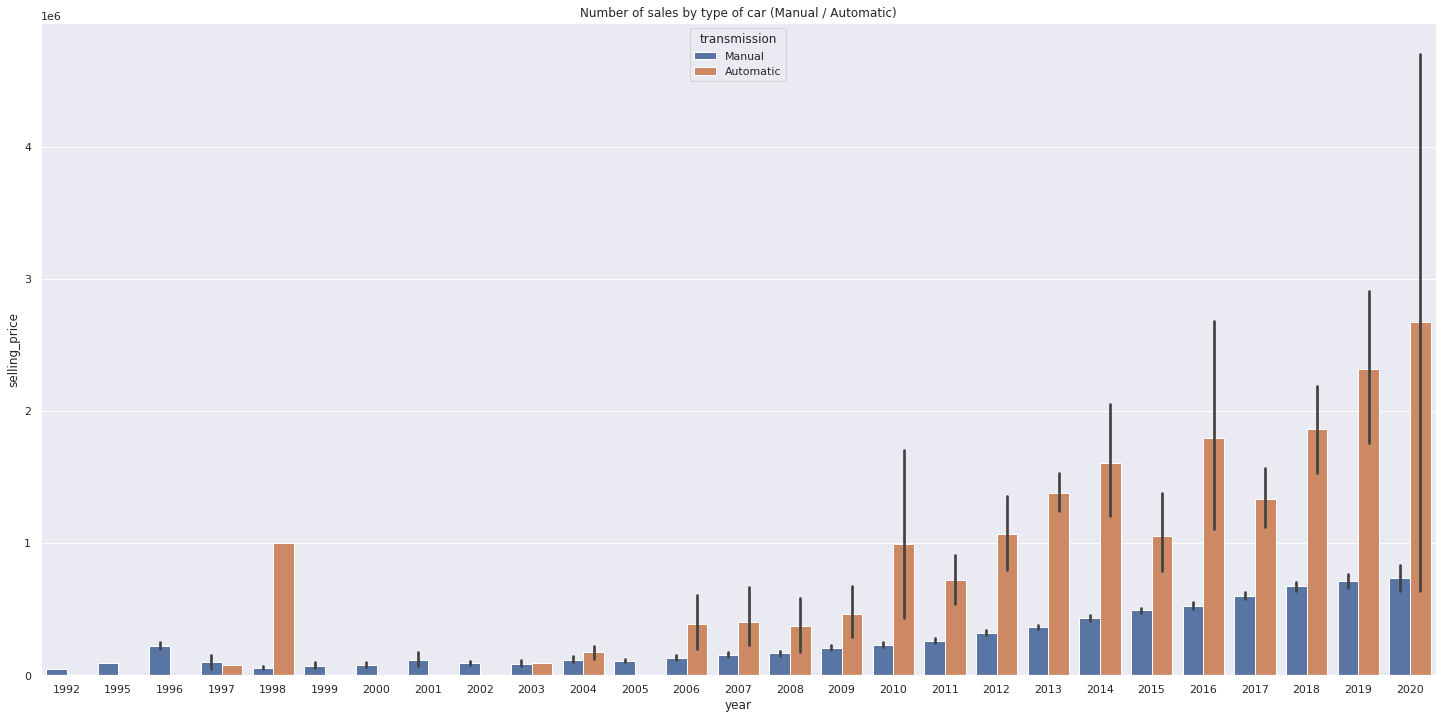

In [181]:
plt.title('Number of sales by type of car (Manual / Automatic)')
sns.barplot( x= 'year', y = 'selling_price', hue = 'transmission', data = df1);

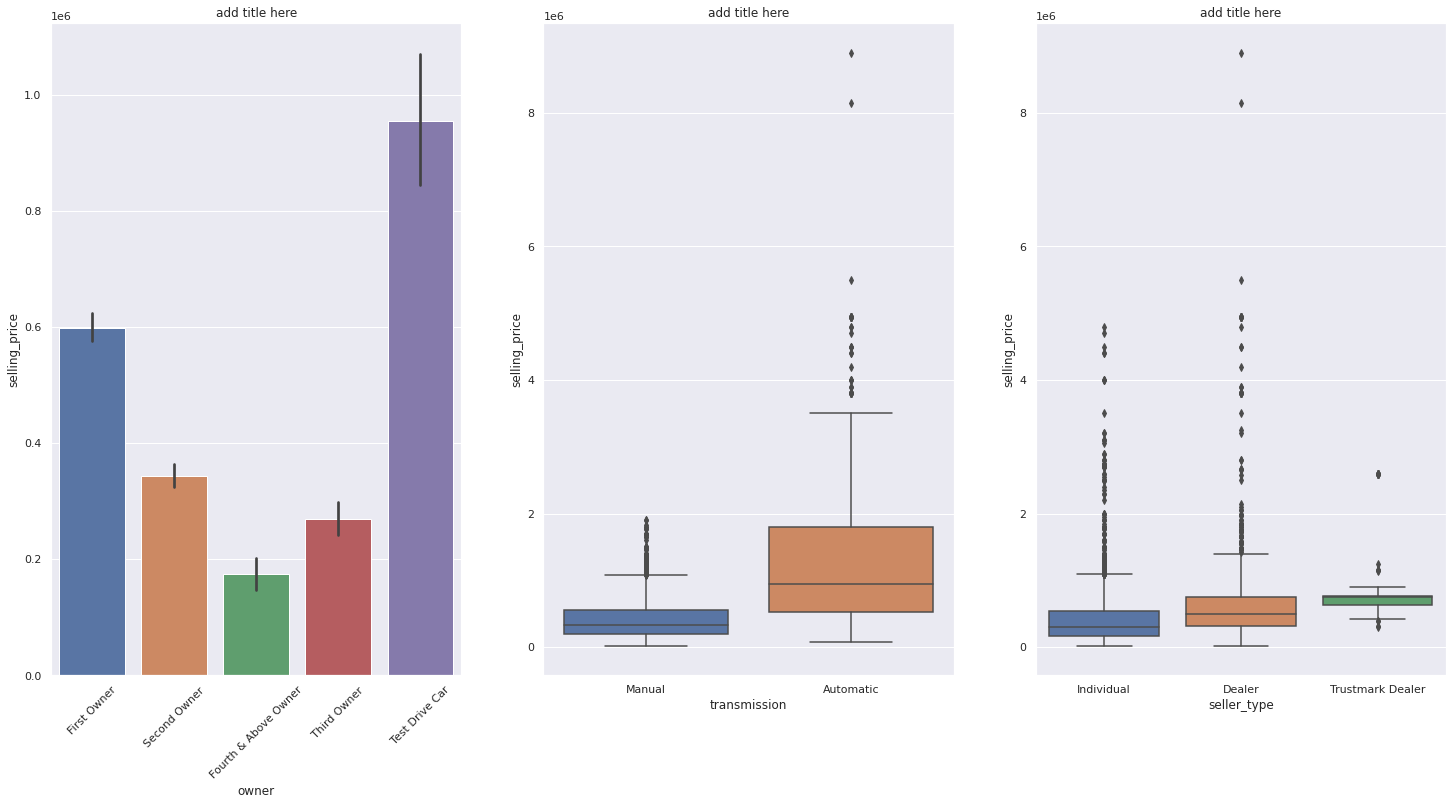

In [185]:
plt.subplot( 1,3,1)
plt.title('add title here')
sns.barplot( x= "owner" , y= 'selling_price' , data =df1)
plt.xticks( rotation = 45);

plt.subplot( 1,3,2)
plt.title('add title here')
sns.boxplot( x= "transmission" , y= 'selling_price' , data =df1)

plt.subplot( 1,3,3)
plt.title('add title here')
sns.boxplot( x= "seller_type", y= 'selling_price', data =df1)


In [171]:
df1.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,selling_price_2,km_driven_2
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner,"(0, 200000]","(40000, 60000]"
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner,"(0, 200000]","(120000, 140000]"
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner,"(400000, 600000]","(580000, 600000]"
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner,"(200000, 400000]","(240000, 260000]"
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner,"(400000, 600000]","(440000, 460000]"


## 2.0 Data Preparation

In [340]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler



In [325]:
df2 = df1.copy()

In [326]:
# drop columns 
cols =['selling_price_2','km_driven_2']
df2 = df2.drop(cols, axis = 1)

In [327]:
# Dividindo as variaveis em features e target X,Y
X  = df2.drop('selling_price', axis = 1)
y = df2['selling_price']

## 2.1.1 Encoding Vars

In [328]:
# Visualizando as variaveis antes do encode
#X.select_dtypes(include='object').head()

label_encoder1 = LabelEncoder()
label_encoder2 = LabelEncoder()
label_encoder3 = LabelEncoder()
label_encoder4 = LabelEncoder()
label_encoder5 = LabelEncoder()



# Encoding de Variaveis
X['name']         = label_encoder1.fit_transform( X['name'] )
X['fuel']         = label_encoder2.fit_transform( X['fuel'] )
X['seller_type']  = label_encoder3.fit_transform( X['seller_type'] )
X['transmission'] = label_encoder4.fit_transform( X['transmission'] )
X['owner']        = label_encoder5.fit_transform( X['owner'] )


1. Dictionary encoding: 
 


In [329]:
X.sample(10)

,name,year,km_driven,fuel,seller_type,transmission,owner
527,1387,2017,41000,1,1,0,0
546,294,2014,29654,4,2,1,0
2838,1002,2015,40000,4,1,1,0
2336,522,2007,80000,1,1,1,2
3840,1337,2011,180000,1,1,1,4
1264,1370,2012,124000,1,1,1,0
1889,812,2006,63230,4,1,1,2
458,922,2018,20000,4,1,1,0
1114,1429,2011,120000,1,1,1,0
1910,379,2016,74000,1,1,0,0


### 2.1 Rescaling Numeric Vars

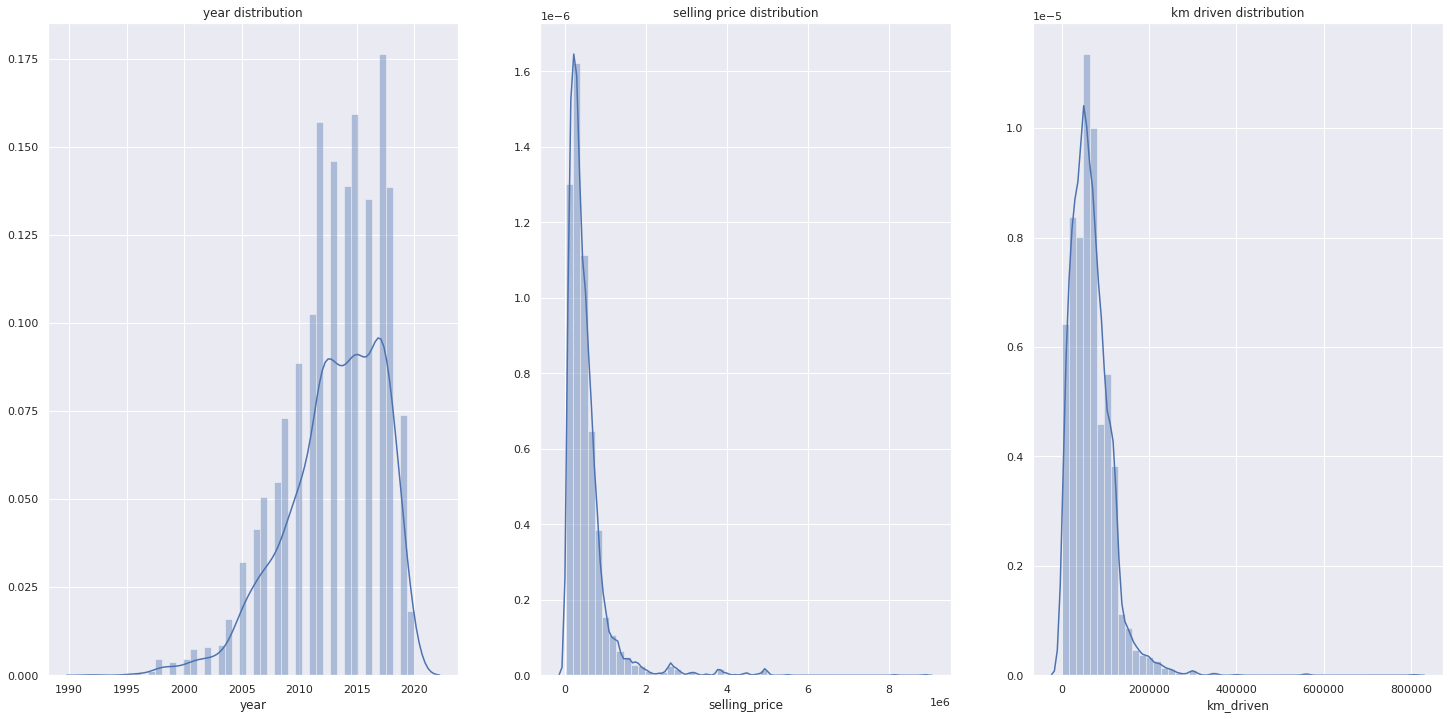

In [330]:
# Entendendo a distribuicao das variaveis antes de scaling
plt.subplot( 1,3,1)
plt.title('year distribution')
sns.distplot(X['year'])


plt.subplot( 1,3,2)
plt.title('selling price distribution')
sns.distplot(y)

plt.subplot( 1,3,3)
plt.title('km driven distribution')
sns.distplot(X['km_driven']);


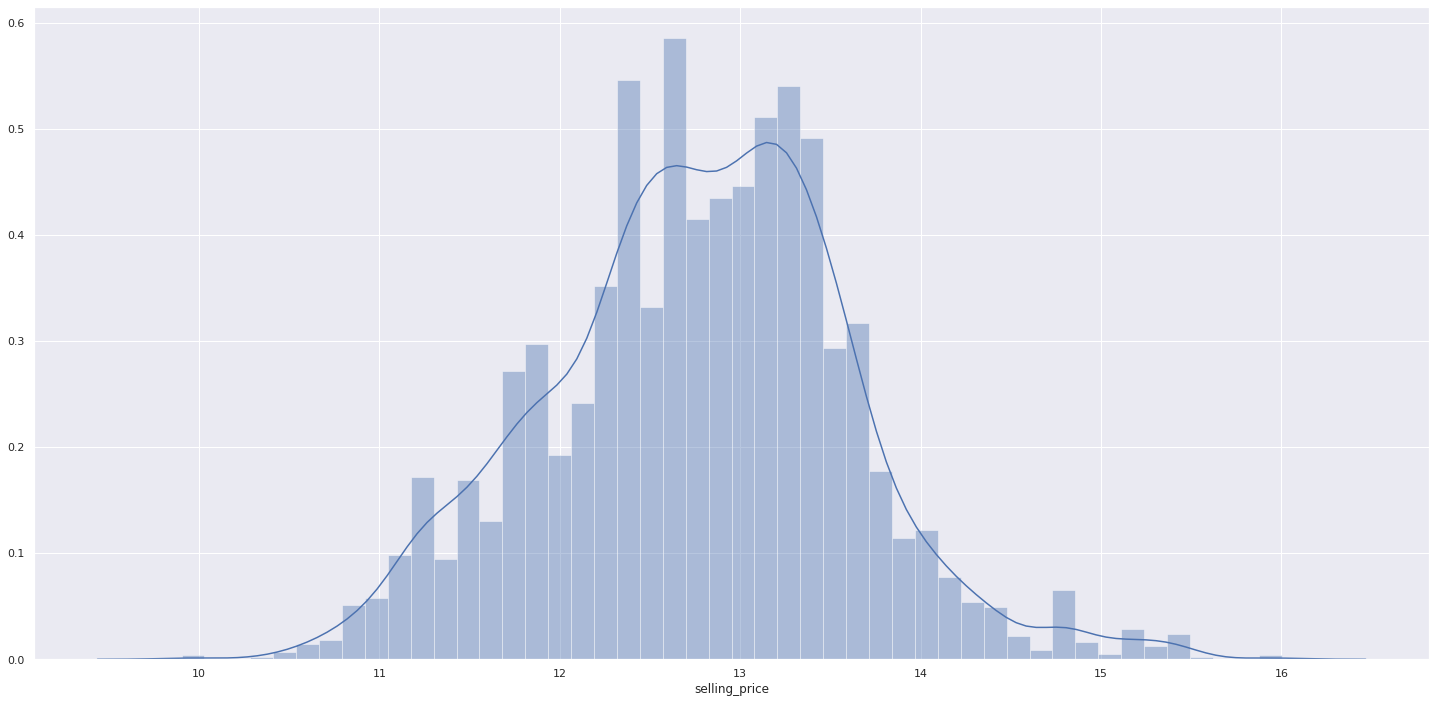

In [331]:
# Aplicando Trabnsformacao logaritmica nos valores de venda
y = np.log1p(y)

# # Plotando a tranformacao 
sns.distplot(y);

In [332]:

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

scaler = MinMaxScaler()
X['km_driven'] = scaler.fit_transform(X[['km_driven']])


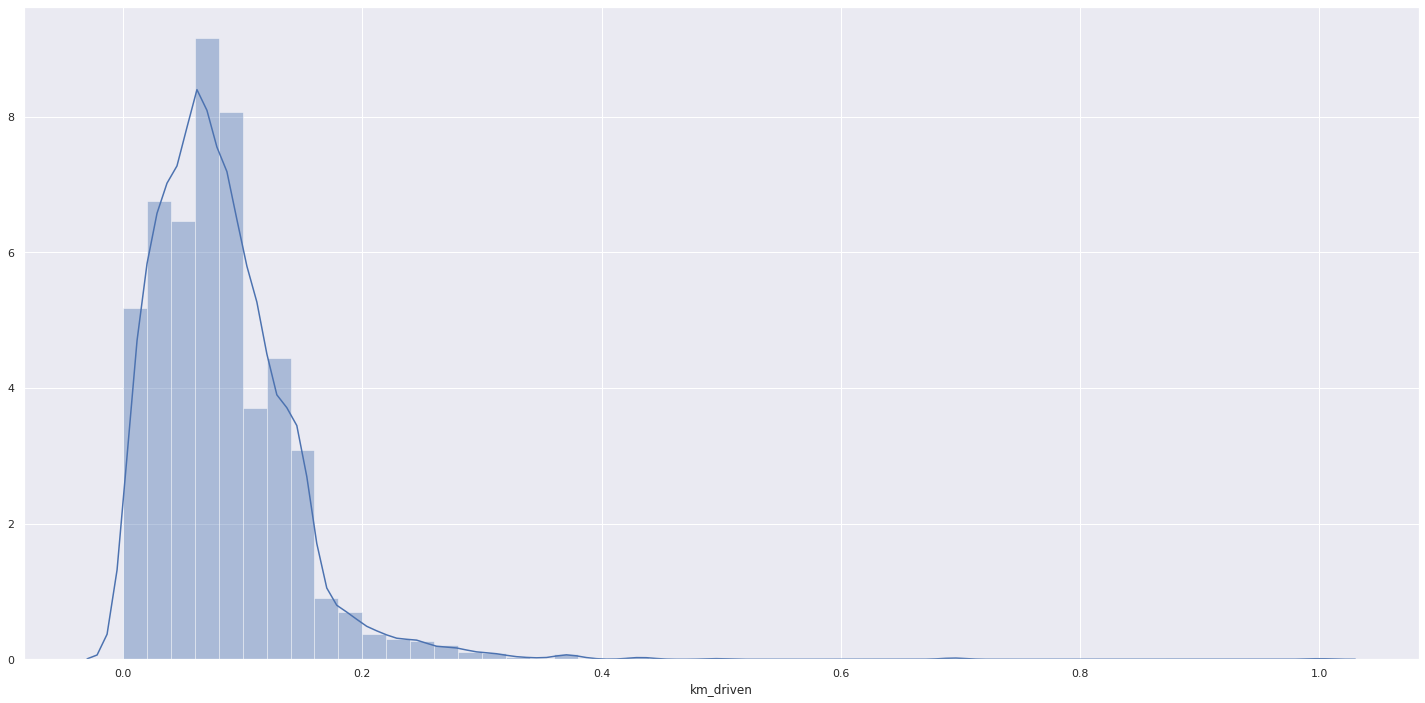

In [357]:
sns.distplot(X['km_driven'])

In [338]:
y.shape

(4340,)

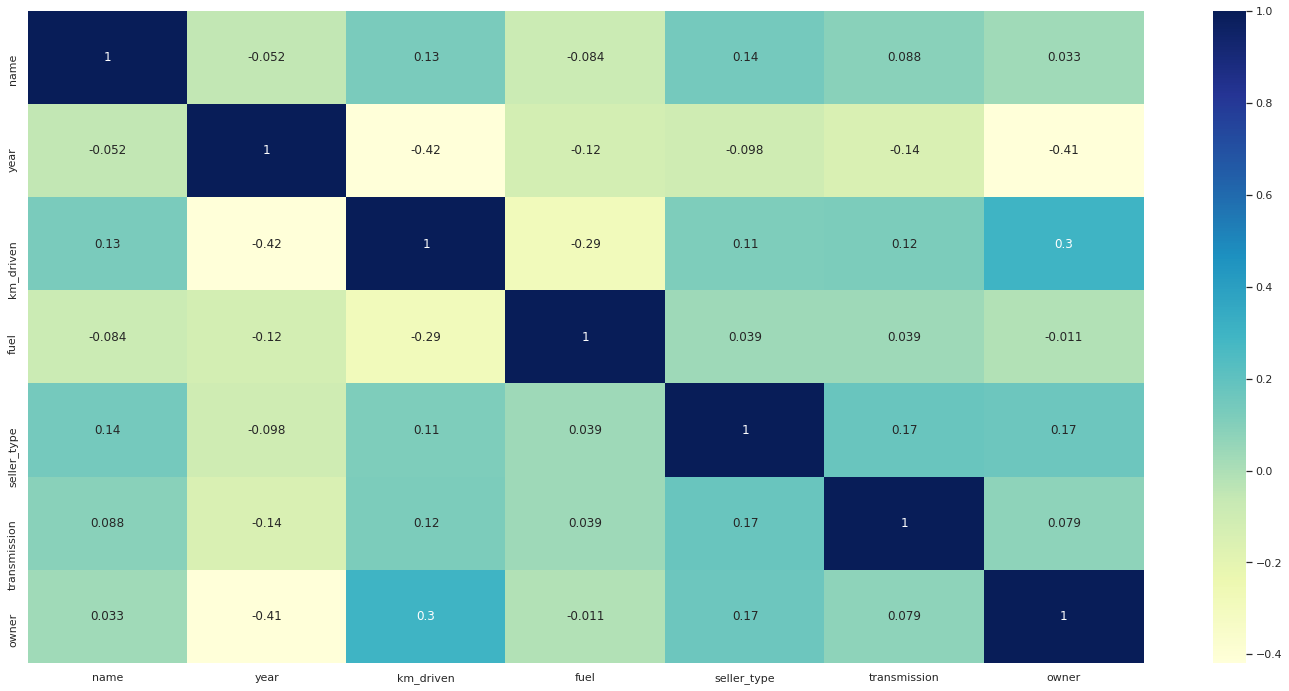

In [396]:
# correlation

# sns.heatmap(X, annot = True, cmap = "YlGnBu") #YlGnBu - color
sns.heatmap( X.corr(method= 'pearson'), annot = True, cmap = "YlGnBu");


# 3.0 Models

In [363]:
from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LinearRegression
from sklearn.ensemble         import RandomForestRegressor

from sklearn.metrics          import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score


In [398]:
cv= 15 # CV value
r_2 = [] # List for r 2 score
CV = [] # list for CV scores mean

# Main function for models
def model(algorithm,x_train_,y_train_,x_test_,y_test_): 
    algorithm.fit(x_train_,y_train_)
    predicts=algorithm.predict(x_test_)
    prediction=pd.DataFrame(predicts)
    R_2=r2_score(y_test_,prediction)
    cross_val=cross_val_score(algorithm,x_train_,y_train_,cv=cv)
    
    # Appending results to Lists 
    r_2.append(R_2)
    CV.append(cross_val.mean())
    
    # Printing results  
    print(algorithm,"\n") 
    print("r_2 score :",R_2,"\n")
    print("CV scores:",cross_val,"\n")
    print("CV scores mean:",cross_val.mean())
    
    # # Plot for prediction vs originals

    # test_index=y_test_.reset_index()["Selling_Price"]
    # ax=test_index.plot(label="originals",figsize=(12,6),linewidth=2,color="r")
    # ax=prediction[0].plot(label = "predictions",figsize=(12,6),linewidth=2,color="g")
    # plt.legend(loc='upper right')
    # plt.title("ORIGINALS VS PREDICTIONS")
    # plt.xlabel("index")
    # plt.ylabel("values")
    # plt.show()

#### help

In [349]:
# MAPE
#y valor real, yhat valores de previsao
def mean_absolute_percentage_error( y, yhat):
  return np.mean( np.abs ( ( y-yhat ) / y ) )


def mean_percentage_error( y, yhat):
  return np.mean(  ( y-yhat ) / y  )



def ml_error( model_name, y, yhat):
  mae = mean_absolute_error(y, yhat)
  mape = mean_absolute_percentage_error(y, yhat)
  rmse = np.sqrt(mean_squared_error( y, yhat))

  return pd.DataFrame( {"Model Name": model_name,
                        "MAE": mae,
                        "MAPE": mape,
                        'RMSE': rmse
                        
                        }, index = [0]) # reset index, pra n dar erro


In [345]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 0)

# Machine Learning Models

In [406]:
# linear Model

lr_model = LinearRegression()

model(lr_model,X_train,y_train,X_test,y_test)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 

r_2 score : 0.47669845130280775 

CV scores: [0.39729026 0.48171429 0.45113698 0.41769884 0.43298533 0.38837239
 0.57211399 0.29032517 0.57032476 0.39517481 0.25613145 0.49618631
 0.42614616 0.52747538 0.50891056] 

CV scores mean: 0.4407991113022828


In [407]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

model(dtr,X_train,y_train,X_test,y_test)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best') 

r_2 score : 0.48954192762729576 

CV scores: [0.8085782  0.79342635 0.49111164 0.64821579 0.68898105 0.83418122
 0.44378155 0.55077864 0.76256068 0.56351078 0.6020209  0.85162449
 0.73134897 0.56962631 0.73534129] 

CV scores mean: 0.6716725243857803


In [408]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor( n_estimators = 2500, n_jobs= 1, random_state= 25)

model(rf,X_train,y_train,X_test,y_test)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2500, n_jobs=1, oob_score=False,
                      random_state=25, verbose=0, warm_start=False) 

r_2 score : 0.7629168754557138 

CV scores: [0.92477193 0.85466022 0.64304778 0.72669802 0.72856399 0.82777902
 0.69604611 0.49039683 0.76397486 0.87191228 0.71604651 0.83705136
 0.71042603 0.82801889 0.84964645] 

CV scores mean: 0.7646026851768487


In [409]:
import xgboost                as xgb
model_xgb = xgb.XGBRegressor( objective= 'reg:squarederror',
                              n_estimators = 2500, # numero de arvores/ ideal os 2500,3000.
                              eta = 0.01,
                              max_depth = 10, # profundidade maxima que a arvore atinge
                              subsample = 0.7, # percentagem da amostragem das variaveis
                              colsample_bytee = 0.9 ).fit(X_train,y_train)


model(model_xgb,X_train,y_train,X_test,y_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytee=0.9, colsample_bytree=1,
             eta=0.01, gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
             n_estimators=2500, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7, verbosity=1) 

r_2 score : 0.7985589622116097 

CV scores: [0.94922485 0.90665894 0.76647548 0.8383156  0.81264812 0.8346334
 0.80285211 0.52880749 0.79012442 0.87317589 0.78291711 0.85623092
 0.71657222 0.86691393 0.91049881] 

CV scores mean: 0.8157366188323106


In [412]:

Model = ["LinearRegression","DecisionTreeRegressor","RandomForestRegressor", "XGBOOST"]
results=pd.DataFrame({'Model': Model,'R Squared': r_2,'CV score mean': CV})
results

ValueError: ignored